# 

# Intro to Scikit-Learn

## Classification

### Data loading

https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-plants-dataset

In [1]:
import platform

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import (
    datasets,
    decomposition,
    linear_model,
    metrics,
    preprocessing,
    model_selection,
)

In [2]:
if platform.system() == "Darwin":
    %config InlineBackend.figure_format="retina"  # For high DPI display

print(sklearn.__version__)  # Version tested on sklearn.__version__ == 1.2.1

sns.set_style("darkgrid")
sns.set_context("notebook")

1.2.1


In [5]:
iris = datasets.load_iris()

ft_names = iris.feature_names

df = pd.DataFrame(iris.data, columns=ft_names)
df["target"] = iris.target
df["name"] = df.target.map(pd.Series(iris.target_names))
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [6]:
std_ft_names = ["s_length_std", "s_width_std", "p_length_std", "p_width_std"]

scaler = preprocessing.StandardScaler()
std_fts = scaler.fit_transform(df[ft_names])

std_df = pd.DataFrame(std_fts, columns=std_ft_names)
std_df.head()

,s_length_std,s_width_std,p_length_std,p_width_std
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444
3,-1.506521,0.098217,-1.283389,-1.315444
4,-1.021849,1.249201,-1.340227,-1.315444


In [7]:
N_COMPS = 2
pca = decomposition.PCA(n_components=N_COMPS)

# Fit and transform data
pca_fts = pca.fit_transform(std_df)

pc_names = pd.Series({i: f"PC{i}" for i in range(1, pca.n_features_in_ + 1)})

pca_df = pd.DataFrame(pca_fts, columns=[*pc_names.loc[1:2]])
pca_df["name"] = df.name
pca_df.head()

,PC1,PC2,name
0,-2.264703,0.480027,setosa
1,-2.080961,-0.674134,setosa
2,-2.364229,-0.341908,setosa
3,-2.299384,-0.597395,setosa
4,-2.389842,0.646835,setosa


In [6]:
# sns.lmplot(pca_df, x="pc1", y="pc2", hue="name", fit_reg=False)
# plt.title("2D PCA Graph")
# plt.show()

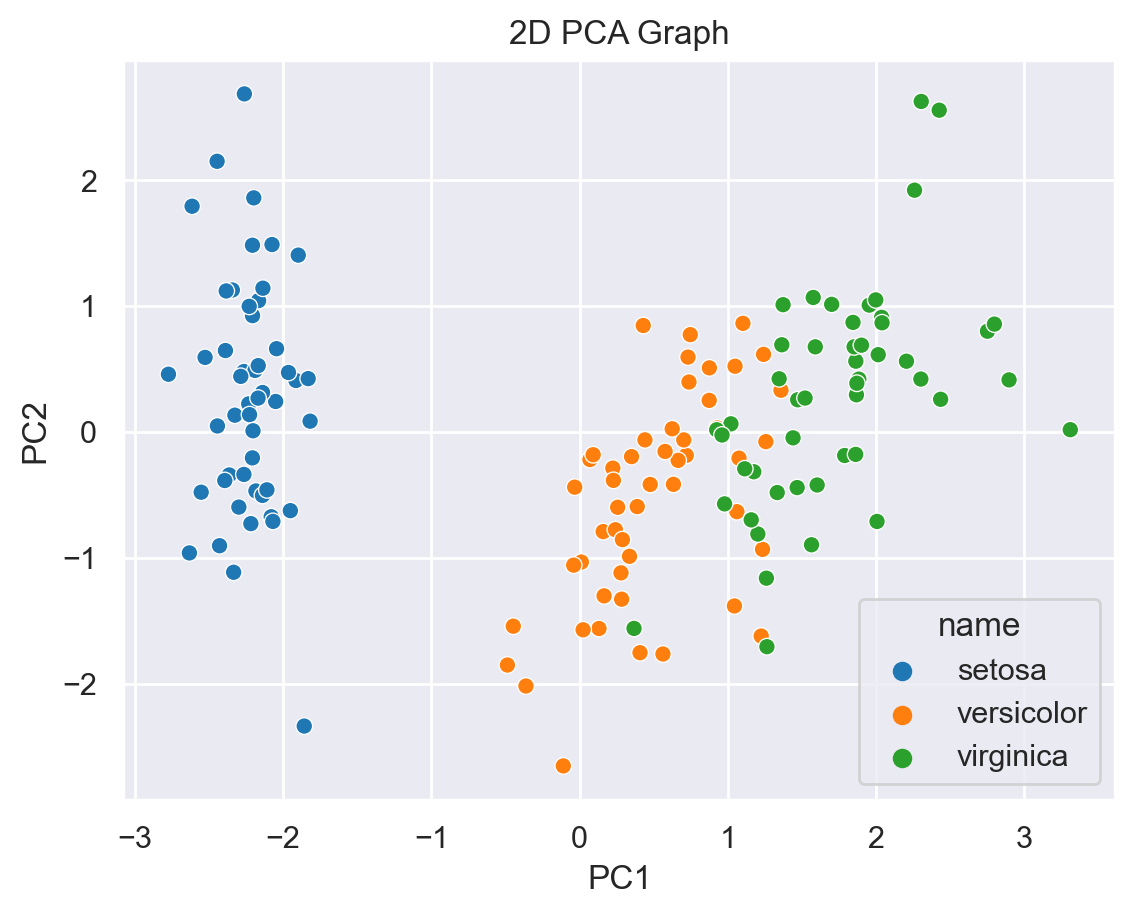

In [8]:
sns.scatterplot(pca_df, x=pc_names[1], y=pc_names[2], hue="name")
plt.title("2D PCA Graph")
plt.show()

In [9]:
load_df = pd.DataFrame(dict(zip(pc_names, pca.components_)))
load_df["ft_name"] = ft_names
load_df.set_index("ft_name", inplace=True)
load_df

,PC1,PC2
ft_name,,
sepal length (cm),0.521066,0.377418
sepal width (cm),-0.269347,0.923296
petal length (cm),0.580413,0.024492
petal width (cm),0.564857,0.066942


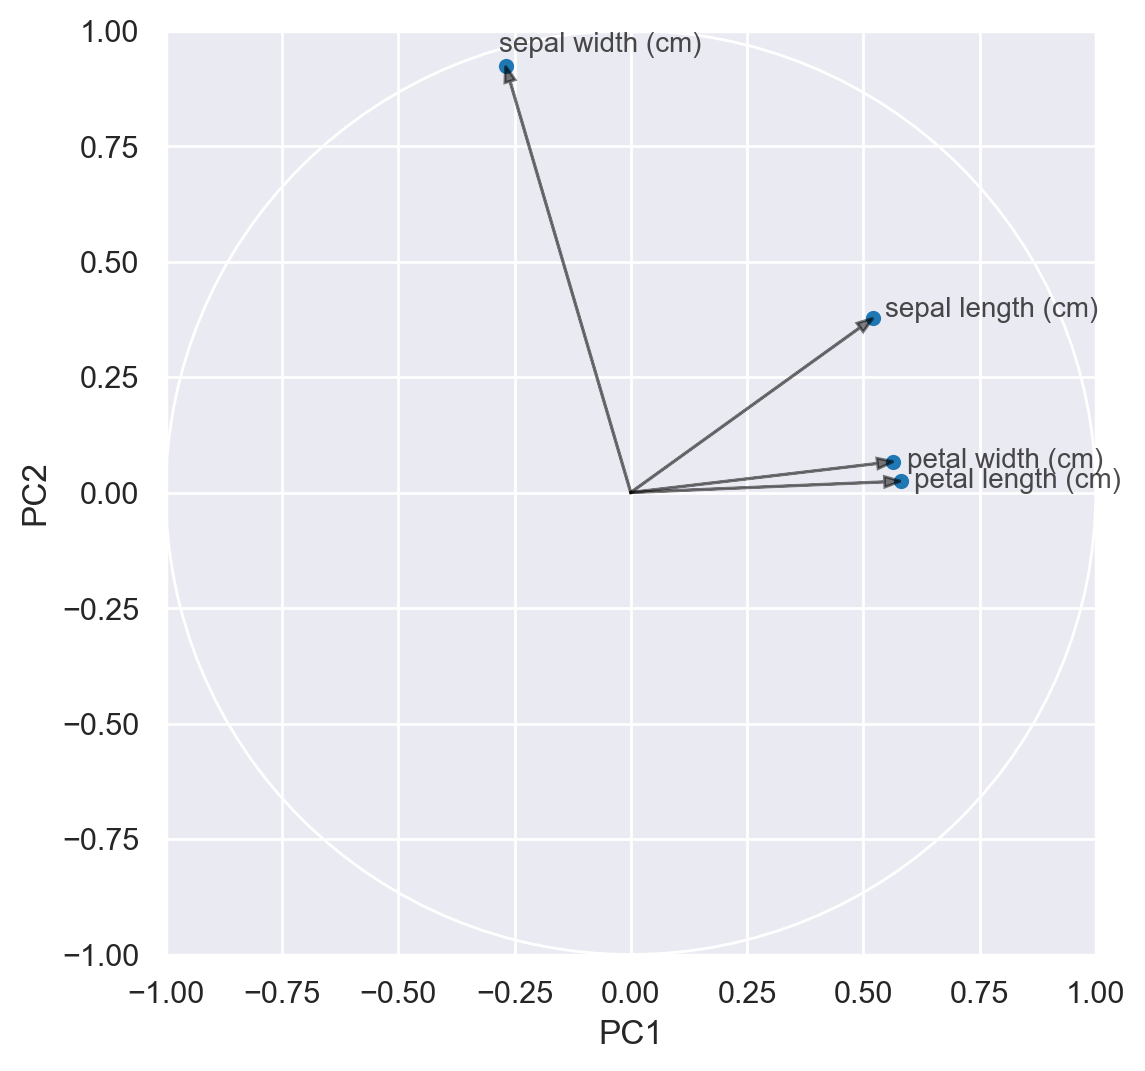

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))

# sns.scatterplot(load_df, x="PC1", y="PC2", hue="ft_name", legend=False, ax=ax)
load_df.plot.scatter(x="PC1", y="PC2", ax=ax)

max_val = load_df.max().max()

for idx, row in load_df.iterrows():
    plt.arrow(
        0,
        0,
        row.PC1,
        row.PC2,
        color="black",
        alpha=0.5,
        linestyle="-",
        head_width=max_val / 40,
        length_includes_head=True,
    )
    plt.text(
        row.PC1 * 1.05,
        row.PC2 * 1.05,
        idx,
        color="black",
        alpha=0.7,
        ha="left",
        va="center",
        fontsize=10,
    )
# plt.plot([0], [0], "o", color="k", ms=270, mfc="none", alpha=0.5)

ax.add_patch(plt.Circle((0, 0), 1, fill=False))

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])

plt.show()

---

### Sensitivity Analysis via Logistic Regression

Note: conversion to a binary classification problem

In [12]:
pca_df["target"] = df.target
# Simplify to binary classification
pca_df["target_bin"] = df.target.map({0: 0, 1: 1, 2: 1})
pca_df

,PC1,PC2,name,target,target_bin
0,-2.264703,0.480027,setosa,0,0
1,-2.080961,-0.674134,setosa,0,0
2,-2.364229,-0.341908,setosa,0,0
3,-2.299384,-0.597395,setosa,0,0
4,-2.389842,0.646835,setosa,0,0
...,...,...,...,...,...
145,1.870503,0.386966,virginica,2,1
146,1.564580,-0.896687,virginica,2,1
147,1.521170,0.269069,virginica,2,1
148,1.372788,1.011254,virginica,2,1


In [13]:
xs = scaler.fit_transform(pca_df[["PC1", "PC2"]])
# xs = pca_df[["PC1", "PC2"]]

xs_train, xs_test, ys_train, ys_test = model_selection.train_test_split(
    xs, pca_df.target_bin, test_size=0.2, random_state=42
)

In [14]:
model = linear_model.LogisticRegression()
model.fit(xs_train, ys_train)

LogisticRegression()

In [15]:
pca_df[["PC1", "PC2"]].std()
# xs.std(axis=0)

PC1    1.714084
PC2    0.959252
dtype: float64

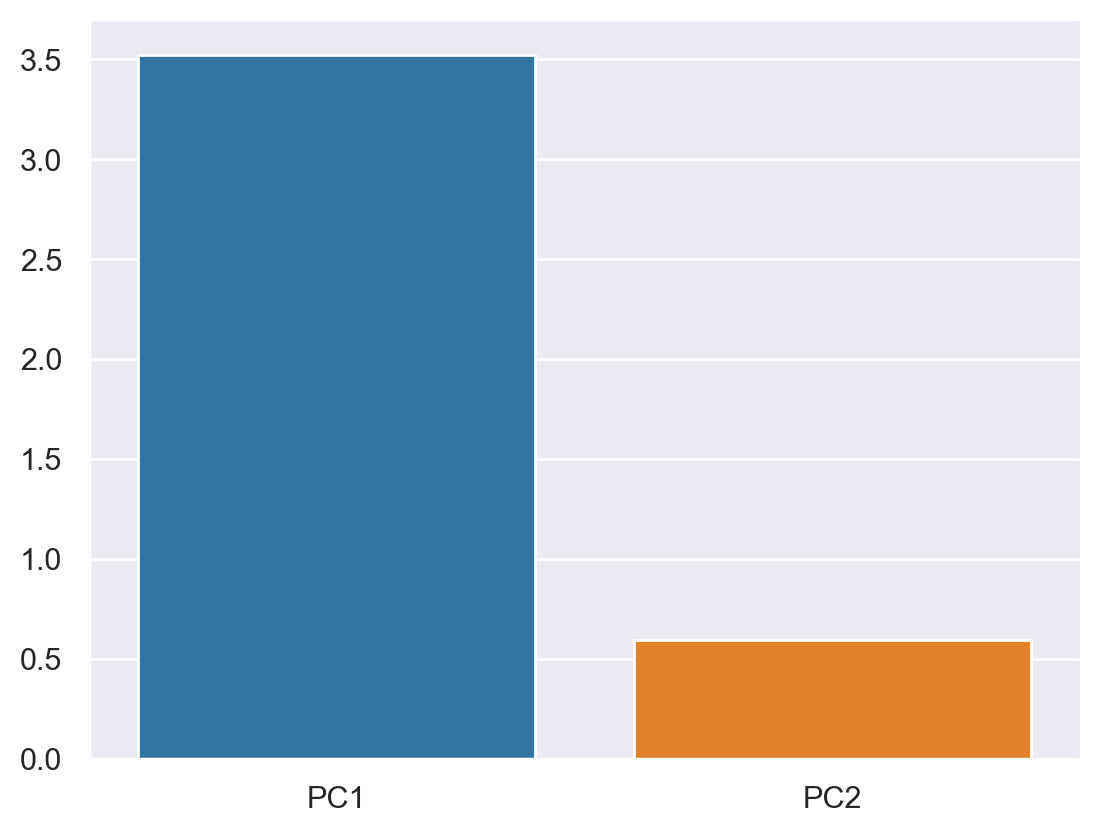

In [16]:
coef_df = pd.DataFrame(model.coef_, columns=["PC1", "PC2"])
sns.barplot(coef_df.abs())
plt.show()

---